In [1]:
import nltk   
import spacy            
import re     
import string            
import numpy as np
import pandas as pd
import random
import collections
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples    # Corpus Twitter
from nltk.tokenize import word_tokenize 
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


False

Lectura de Corpus

In [2]:
nltk.download('twitter_samples')

[nltk_data] Error loading twitter_samples: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


False

In [3]:
pos_tweets = twitter_samples.strings('positive_tweets.json') #tweets positivos
neg_tweets = twitter_samples.strings('negative_tweets.json') #tweets negativos

print("Positive tweets: ", len(pos_tweets))
print("Negative tweets: ", len(neg_tweets))

Positive tweets:  5000
Negative tweets:  5000


Preprocesamiento


1. LowerCase
2. Lematización / Stemming
3. Remover stopword
4. Remover signos de puntuación
4. Remover urls y manejadores





In [47]:
def custom_tokenizer(nlp):
    special_cases = {":)": [{"ORTH": ":)"}], ":(": [{"ORTH": ":("}]}
    simple_url_re = re.compile(r'''^https?://''')
    suffixes = nlp.Defaults.suffixes + [r'''-+$''',]
    suffix_regex = spacy.util.compile_suffix_regex(suffixes)
    return spacy.tokenizer.Tokenizer(nlp.vocab, rules=special_cases, suffix_search=suffix_regex.search, url_match=simple_url_re.match)

nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = custom_tokenizer(nlp)


In [48]:
def normalization(data, regularization="lemma", language='english'):
  stopwords = nltk.corpus.stopwords.words(language)
  ps = PorterStemmer()
  normalized_data = []
  
  for tweet in data:
    tweet = re.sub(r'^RT[\s]+', '', tweet) # identificar retweets
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet) #eliminar links
    tweet = re.sub(r'#', '', tweet) #eliminar símbolo gato
    tweet = re.sub(r'@\w+', '', tweet) #eliminar palabras que inicias con @
    tweet = re.sub(r'\d+', '', tweet) #eliminar números
    tweet = re.sub(' +', ' ', tweet) #quitar espacios

    if regularization == "stem":
      tweetTokenizer = TweetTokenizer()
      words = tweetTokenizer.tokenize(tweet)
      tokens = [ps.stem(w) for w in words]
    if regularization == "lemma":
      doc = nlp(tweet)
      tokens = [token.lemma_ for token in doc]
    else:
      doc = nlp(tweet)
      tokens = [token.text for token in doc]
    
    normalized_tweets = [w.lower() for w in tokens if w.lower() not in stopwords and not w==' ' and w not in string.punctuation]
    normalized_data.append(normalized_tweets)
  return normalized_data

Create Vocabulary and frequency dictionaries

In [69]:
norm_pos = normalization(pos_tweets)
norm_neg = normalization(neg_tweets)
all_tweets = norm_pos + norm_neg
at = [w for tweet in all_tweets for w in tweet]
fd = nltk.FreqDist(at)
vocabulary = sorted(list(fd.keys()))

In [70]:
def build_frequencies(normalized_tweets, sentiment):
    one_list = [w for tweet in normalized_tweets for w in tweet]
    fd = nltk.FreqDist(one_list)
    z = zip(list(fd.keys()),list(fd.values()))
    freqs={}
    for word, freq in z:
        freqs[(word,sentiment)] = freq
    return freqs

In [71]:
pos_freqs_dict = build_frequencies(norm_pos,1)
neg_freqs_dict = build_frequencies(norm_neg,0)

In [89]:
pos_freqs_dict

{('followfriday', 1): 25,
 ('top', 1): 30,
 ('engage', 1): 7,
 ('member', 1): 16,
 ('community', 1): 32,
 ('week', 1): 84,
 (':)', 1): 3693,
 ('hey', 1): 76,
 ('james', 1): 7,
 ('odd', 1): 2,
 (':/', 1): 5,
 ('please', 1): 97,
 ('call', 1): 37,
 ('contact', 1): 7,
 ('centre', 1): 2,
 ('able', 1): 8,
 ('assist', 1): 1,
 ('many', 1): 32,
 ('thank', 1): 631,
 ('listen', 1): 16,
 ('last', 1): 47,
 ('night', 1): 69,
 ('bleed', 1): 2,
 ('amazing', 1): 47,
 ('track', 1): 5,
 ('scotland', 1): 2,
 ('congrats', 1): 3,
 ('yeaaaah', 1): 1,
 ('yippppy', 1): 1,
 ('accnt', 1): 2,
 ('verify', 1): 2,
 ('rqst', 1): 1,
 ('succee', 1): 1,
 ('get', 1): 266,
 ('blue', 1): 9,
 ('tick', 1): 1,
 ('mark', 1): 1,
 ('fb', 1): 6,
 ('profile', 1): 2,
 ('day', 1): 241,
 ('one', 1): 131,
 ('irresistible', 1): 2,
 ('\n', 1): 523,
 ('flipkartfashionfriday', 1): 17,
 ('like', 1): 230,
 ('keep', 1): 64,
 ('lovely', 1): 62,
 ('customer', 1): 3,
 ('wait', 1): 68,
 ('long', 1): 38,
 ('hope', 1): 126,
 ('enjoy', 1): 77,
 ('h

In [72]:
#Get maximun frequency value
def get_frequency_max_value(pos_freqs_dict,neg_freqs_dict):
    counter_pos = collections.Counter(pos_freqs_dict)
    most_common_pos = counter_pos.most_common(1)[0][1]
    counter_neg = collections.Counter(neg_freqs_dict)
    most_common_neg = counter_neg.most_common(1)[0][1]
    return most_common_pos if most_common_pos >= most_common_neg else most_common_neg



For each tweet a count of the words in its positive class and in its negative class is given. -> [bias, positive class count, negative class count]

In [73]:
def build_features_vectors(norm_tweets, pos_freqs_dict, neg_freqs_dict, normalize = True):
    max_value = get_frequency_max_value(pos_freqs_dict,neg_freqs_dict)
    bias =1
    vectors = []
    for tweet in norm_tweets:
        count_pos = 0
        count_neg = 0
        for w in list(set(tweet)):
            count_pos += pos_freqs_dict.get((w,1),0)
            count_neg += neg_freqs_dict.get((w,0),0)
        if normalize:
            vectors.append([bias, round(count_pos/max_value,4), round(count_neg/max_value,4)])
        else:
            vectors.append([bias, count_pos, count_neg])
    return vectors

In [74]:
X_features = build_features_vectors(all_tweets, pos_freqs_dict, neg_freqs_dict, normalize = True)
tags = [1]*len(norm_pos) + [0]*len(norm_neg)
print(X_features[:10])

[[1, 0.8404, 0.0158], [1, 0.9942, 0.1094], [1, 0.8391, 0.0348], [1, 0.7991, 0.0009], [1, 0.9139, 0.1031], [1, 0.944, 0.1135], [1, 1.0102, 0.1059], [1, 0.8765, 0.0659], [1, 0.1775, 0.0631], [1, 0.1068, 0.0474]]


In [75]:
"""Shuffle list"""
tuple_list = list(zip(X_features, tags)) #list of tuples (X,y)
random.seed(30)
random.shuffle(tuple_list)
X_, y_ = zip(*tuple_list)

X = list(X_)
y = list(y_)

In [76]:
"""split corpus into test(20%) and train(80%)"""
test_percentage = 0.2
split = int(len(X) * test_percentage)
X_test = X[:split]
y_test = y[:split]
X_train = X[split:]
y_train = y[split:]

m_train = len(X_train) #number of examples in X_train
m_test = len(X_test) #number of examples in X_test
n = len(X_train[0]) #features

In [77]:
"""Convert to array"""
import numpy as np
X_train = np.array(X_train).T
X_test = np.array(X_test).T
y_train = np.array(y_train)
y_test = np.array(y_test)
print('features: ', n)
print('shape X_train: ', X_train.shape)
print('shape X_test: ', X_test.shape)

y_train = y_train.reshape((m_train, 1))
y_test = y_test.reshape((m_test, 1))
print('shape y_train: ', y_train.shape)
print('shape y_test: ', y_test.shape)

features:  3
shape X_train:  (3, 8000)
shape X_test:  (3, 2000)
shape y_train:  (8000, 1)
shape y_test:  (2000, 1)


In [78]:
def sigmoid(z):
  sigmoide = np.where(z < 0, np.exp(z)/(1 + np.exp(z)), 1/(1 + np.exp(-z)))
  return sigmoide
  #return 1/(1 + np.exp(-z)) 

In [79]:
def log_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps) #limitar los valores del array en el rango eps y 1 - eps
    loss = - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)
    return np.mean(loss)

In [80]:
def gradient_descent(h_theta, y, X):
  return (1/len(y)) * np.dot((h_theta - y).T,X.T) # 1xm dot mxn ->1xn

In [81]:
""" Train """
epochs = 1500
learning_rate = 5 #normalize = True
#learning_rate = .00001 #normalize = False
costs = []
theta = np.zeros((n,1)) #-> nx1

for i in range(epochs):
  z = np.dot(theta.T, X_train) #->1xm
  h_theta = sigmoid(z.T)#->mx1, h_theta or y_pred
  #Calculate cost
  cost = log_loss(y_train,h_theta) #scalar
  costs.append(cost)
  if i%100 == 0:
    print('Cost in epoch', i, 'is', cost)
  #Gradient descent
  d_theta = gradient_descent(h_theta, y_train, X_train).T #->nx1
  theta = theta - learning_rate * d_theta #->nx1

Cost in epoch 0 is 0.6931471805599454
Cost in epoch 100 is 0.10440053926493272
Cost in epoch 200 is 0.09964194678579122
Cost in epoch 300 is 0.09730042947140422
Cost in epoch 400 is 0.09574415628911316
Cost in epoch 500 is 0.09457975249083928
Cost in epoch 600 is 0.09365335810411485
Cost in epoch 700 is 0.09288810787043565
Cost in epoch 800 is 0.09223942738425901
Cost in epoch 900 is 0.09167883037259109
Cost in epoch 1000 is 0.09118687600141584
Cost in epoch 1100 is 0.09074967393488184
Cost in epoch 1200 is 0.09035696553224652
Cost in epoch 1300 is 0.09000098442862635
Cost in epoch 1400 is 0.08967573712598402


Text(0.5, 1.0, 'Learning curve')

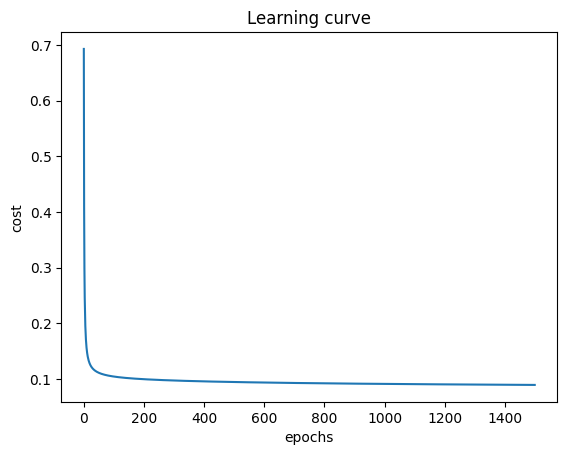

In [82]:
#Plot train cost
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title("Learning curve")

In [83]:
def evaluation(theta,X):
  #X -> nxm
  #theta.T ->1xn
  z = np.dot(theta.T, X) #->1xm
  return sigmoid(z.T)#->mx1

In [84]:
def classify_tag(y_pred_list,threshold):
  return [1 if y >= threshold else 0 for y in y_pred_list]

In [85]:
def confusion_matrix_values(y_pred, y_label):
  TP, FN, FP, TN = 0 , 0 , 0, 0
  for i in range(len(y_pred)):
    if y_pred[i] == 1 and  y_label[i] == 1:
      TP = TP + 1
    elif y_pred[i] == 1 and y_label[i] == 0:
      FP = FP + 1
    elif y_pred[i] == 0 and y_label[i] == 1:
      FN = FN + 1
    else:
      TN = TN + 1
  return TP, FN, FP, TN

In [86]:
"""Measures"""

def measures(TP, FN, FP, TN):
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  fallout = FP / (FP + TN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F = (precision * recall) / (precision + recall)
  F1 = (2 * precision * recall)/(precision + recall)
  print("Presicion: ", precision) #mide la fracción de los verdaderos positivos en relación con los falsos positivos
  print("Recall: ", recall) #mide la fracción de los verdaderos positivos en relación con los falsos negativos.
  print("F: ", F)
  print("F1: ", F1) #F1 es una medida combinada de precisión y recall que proporciona un equilibrio entre estas dos métricas.
  print("Fallout: ", fallout) # tasa de falsos negativos
  print("Accuracy: ", accuracy) #proporción de ejemplos clasificados correctamente sobre el total de ejemplos

In [87]:
"""Evaluation for Train"""

threshold = 0.5
y_train_pred_prob = evaluation(theta,X_train)
y_train_pred = classify_tag(y_train_pred_prob, threshold)
TP, FN, FP, TN = confusion_matrix_values(y_train_pred, y_train)
print(TP,FN,FP,TN)
measures(TP,FN,FP,TN)

3980 5 372 3643
Presicion:  0.9145220588235294
Recall:  0.998745294855709
F:  0.477389948422694
F1:  0.954779896845388
Fallout:  0.09265255292652554
Accuracy:  0.952875


In [88]:
"""Evaluation for Test"""

y_test_pred_prob = evaluation(theta,X_test)
y_test_pred = classify_tag(y_test_pred_prob, threshold) #Classify to 0 (ham) or 1 (spam)
TP, FN, FP, TN = confusion_matrix_values(y_test_pred, y_test)
print(TP,FN,FP,TN)
measures(TP,FN,FP,TN)

1011 4 98 887
Presicion:  0.9116321009918846
Recall:  0.9960591133004926
F:  0.4759887005649717
F1:  0.9519774011299434
Fallout:  0.09949238578680203
Accuracy:  0.949


Usando scikit-learn

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=50)
target_names = ['class 0', 'class 1']

In [98]:
# Creamos el modelo de regresión logística
modelo = LogisticRegression()
# Entrenamos el modelo con los datos de entrenamiento
modelo.fit(X_train, y_train)
predicciones = modelo.predict(X_test)
# Evaluamos el modelo
puntaje = modelo.score(X_test, y_test)
# Imprimimos el puntaje obtenido
print("Puntaje: ", puntaje)
print(classification_report(y_test, predicciones, target_names=target_names, digits=4))

Puntaje:  0.942
              precision    recall  f1-score   support

     class 0     1.0000    0.8822    0.9374       985
     class 1     0.8974    1.0000    0.9459      1015

    accuracy                         0.9420      2000
   macro avg     0.9487    0.9411    0.9417      2000
weighted avg     0.9479    0.9420    0.9418      2000

